In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
args = argparse.Namespace(name = "ConvMixer", 
                          batch_size = 512,
                          scale = 0.75,
                          reprob = 0.25,
                          ra_m = 8,
                          ra_n = 1,
                          jitter = 0.1,
                          hdim = 256,
                          depth = 8,
                          psize = 2,
                          conv_ks = 5,
                          wd = 0.005,
                          clip_norm = 'store_true',
                          epochs = 50,
                          lr_max = 0.05,
                          workers = 2)

In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

In [ ]:
def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [ ]:
# augmentation 포함된 변환
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [ ]:
# augmentation 제외
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0, 1.0)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    #transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
    #transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=args.workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=args.workers)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
model = ConvMixer(args.hdim, args.depth, patch_size=args.psize, kernel_size=args.conv_ks, n_classes=10)
model = nn.DataParallel(model).cuda()

In [ ]:
lr_schedule = lambda t: np.interp([t], [0, args.epochs*2//5, args.epochs*4//5, args.epochs], 
                                  [0, args.lr_max, args.lr_max/20.0, 0])[0]

opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [ ]:
print(lr_schedule(10))

0.025


In [ ]:
train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

lr_list = []
time_list = []

In [ ]:
# train & test

for epoch in tqdm(range(args.epochs)):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    test_loss = 0 ##################################

    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if args.clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)


        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                test_loss_tmp = criterion(output, y) ###################


            test_loss += test_loss_tmp.item() * y.size(0) ##############

            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)


    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc/n)    
    test_acc_list.append(test_acc/m)
    lr_list.append(lr)
    time_list.append(time.time() - start)

    print(f'[{args.name}] Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')

  2%|▏         | 1/50 [00:27<22:07, 27.10s/it]

[ConvMixer] Epoch: 0 | Train Acc: 0.4659, Test Acc: 0.5752, Time: 27.1, lr: 0.002500


  4%|▍         | 2/50 [00:48<18:45, 23.46s/it]

[ConvMixer] Epoch: 1 | Train Acc: 0.6802, Test Acc: 0.6732, Time: 20.9, lr: 0.005000


  6%|▌         | 3/50 [01:09<17:42, 22.61s/it]

[ConvMixer] Epoch: 2 | Train Acc: 0.7721, Test Acc: 0.7314, Time: 21.6, lr: 0.007500


  8%|▊         | 4/50 [01:31<17:06, 22.32s/it]

[ConvMixer] Epoch: 3 | Train Acc: 0.8178, Test Acc: 0.7720, Time: 21.9, lr: 0.010000


 10%|█         | 5/50 [01:53<16:34, 22.09s/it]

[ConvMixer] Epoch: 4 | Train Acc: 0.8437, Test Acc: 0.7737, Time: 21.7, lr: 0.012500


 12%|█▏        | 6/50 [02:14<16:03, 21.90s/it]

[ConvMixer] Epoch: 5 | Train Acc: 0.8604, Test Acc: 0.7428, Time: 21.5, lr: 0.015000


 14%|█▍        | 7/50 [02:36<15:36, 21.77s/it]

[ConvMixer] Epoch: 6 | Train Acc: 0.8768, Test Acc: 0.7987, Time: 21.5, lr: 0.017500


 16%|█▌        | 8/50 [02:57<15:13, 21.74s/it]

[ConvMixer] Epoch: 7 | Train Acc: 0.8892, Test Acc: 0.8050, Time: 21.7, lr: 0.020000


 18%|█▊        | 9/50 [03:20<15:00, 21.96s/it]

[ConvMixer] Epoch: 8 | Train Acc: 0.8956, Test Acc: 0.7774, Time: 22.4, lr: 0.022500


 20%|██        | 10/50 [03:41<14:31, 21.79s/it]

[ConvMixer] Epoch: 9 | Train Acc: 0.9040, Test Acc: 0.8148, Time: 21.4, lr: 0.025000


 22%|██▏       | 11/50 [04:03<14:06, 21.70s/it]

[ConvMixer] Epoch: 10 | Train Acc: 0.9073, Test Acc: 0.8147, Time: 21.5, lr: 0.027500


 24%|██▍       | 12/50 [04:24<13:42, 21.65s/it]

[ConvMixer] Epoch: 11 | Train Acc: 0.9142, Test Acc: 0.7264, Time: 21.5, lr: 0.030000


 26%|██▌       | 13/50 [04:46<13:21, 21.65s/it]

[ConvMixer] Epoch: 12 | Train Acc: 0.9179, Test Acc: 0.8196, Time: 21.6, lr: 0.032500


 28%|██▊       | 14/50 [05:07<12:57, 21.61s/it]

[ConvMixer] Epoch: 13 | Train Acc: 0.9236, Test Acc: 0.7944, Time: 21.5, lr: 0.035000


 30%|███       | 15/50 [05:29<12:35, 21.58s/it]

[ConvMixer] Epoch: 14 | Train Acc: 0.9219, Test Acc: 0.7499, Time: 21.5, lr: 0.037500


 32%|███▏      | 16/50 [05:51<12:13, 21.57s/it]

[ConvMixer] Epoch: 15 | Train Acc: 0.9265, Test Acc: 0.8167, Time: 21.6, lr: 0.040000


 34%|███▍      | 17/50 [06:12<11:51, 21.55s/it]

[ConvMixer] Epoch: 16 | Train Acc: 0.9310, Test Acc: 0.8128, Time: 21.5, lr: 0.042500


 36%|███▌      | 18/50 [06:34<11:30, 21.57s/it]

[ConvMixer] Epoch: 17 | Train Acc: 0.9328, Test Acc: 0.8127, Time: 21.6, lr: 0.045000


 38%|███▊      | 19/50 [06:55<11:07, 21.53s/it]

[ConvMixer] Epoch: 18 | Train Acc: 0.9303, Test Acc: 0.8069, Time: 21.4, lr: 0.047500


 40%|████      | 20/50 [07:17<10:51, 21.73s/it]

[ConvMixer] Epoch: 19 | Train Acc: 0.9311, Test Acc: 0.8280, Time: 22.2, lr: 0.050000


 42%|████▏     | 21/50 [07:39<10:27, 21.64s/it]

[ConvMixer] Epoch: 20 | Train Acc: 0.9415, Test Acc: 0.8221, Time: 21.4, lr: 0.047625


 44%|████▍     | 22/50 [08:00<10:04, 21.59s/it]

[ConvMixer] Epoch: 21 | Train Acc: 0.9528, Test Acc: 0.8223, Time: 21.5, lr: 0.045250


 46%|████▌     | 23/50 [08:22<09:41, 21.53s/it]

[ConvMixer] Epoch: 22 | Train Acc: 0.9584, Test Acc: 0.8432, Time: 21.4, lr: 0.042875


 48%|████▊     | 24/50 [08:43<09:19, 21.50s/it]

[ConvMixer] Epoch: 23 | Train Acc: 0.9612, Test Acc: 0.8227, Time: 21.4, lr: 0.040500


 50%|█████     | 25/50 [09:04<08:57, 21.49s/it]

[ConvMixer] Epoch: 24 | Train Acc: 0.9684, Test Acc: 0.8499, Time: 21.4, lr: 0.038125


 52%|█████▏    | 26/50 [09:26<08:35, 21.46s/it]

[ConvMixer] Epoch: 25 | Train Acc: 0.9764, Test Acc: 0.8362, Time: 21.4, lr: 0.035750


 54%|█████▍    | 27/50 [09:47<08:13, 21.47s/it]

[ConvMixer] Epoch: 26 | Train Acc: 0.9770, Test Acc: 0.8404, Time: 21.5, lr: 0.033375


 56%|█████▌    | 28/50 [10:09<07:52, 21.46s/it]

[ConvMixer] Epoch: 27 | Train Acc: 0.9769, Test Acc: 0.8336, Time: 21.4, lr: 0.031000


 58%|█████▊    | 29/50 [10:30<07:31, 21.48s/it]

[ConvMixer] Epoch: 28 | Train Acc: 0.9846, Test Acc: 0.8590, Time: 21.5, lr: 0.028625


 60%|██████    | 30/50 [10:52<07:09, 21.46s/it]

[ConvMixer] Epoch: 29 | Train Acc: 0.9870, Test Acc: 0.8546, Time: 21.4, lr: 0.026250


 62%|██████▏   | 31/50 [11:15<06:56, 21.90s/it]

[ConvMixer] Epoch: 30 | Train Acc: 0.9909, Test Acc: 0.8715, Time: 22.9, lr: 0.023875


 64%|██████▍   | 32/50 [11:36<06:31, 21.75s/it]

[ConvMixer] Epoch: 31 | Train Acc: 0.9940, Test Acc: 0.8688, Time: 21.4, lr: 0.021500


 66%|██████▌   | 33/50 [11:57<06:08, 21.65s/it]

[ConvMixer] Epoch: 32 | Train Acc: 0.9964, Test Acc: 0.8754, Time: 21.4, lr: 0.019125


 68%|██████▊   | 34/50 [12:19<05:44, 21.52s/it]

[ConvMixer] Epoch: 33 | Train Acc: 0.9979, Test Acc: 0.8823, Time: 21.2, lr: 0.016750


 70%|███████   | 35/50 [12:40<05:21, 21.43s/it]

[ConvMixer] Epoch: 34 | Train Acc: 0.9991, Test Acc: 0.8873, Time: 21.2, lr: 0.014375


 72%|███████▏  | 36/50 [13:01<04:58, 21.34s/it]

[ConvMixer] Epoch: 35 | Train Acc: 0.9997, Test Acc: 0.8898, Time: 21.1, lr: 0.012000


 74%|███████▍  | 37/50 [13:22<04:36, 21.27s/it]

[ConvMixer] Epoch: 36 | Train Acc: 1.0000, Test Acc: 0.8912, Time: 21.1, lr: 0.009625


 76%|███████▌  | 38/50 [13:43<04:14, 21.24s/it]

[ConvMixer] Epoch: 37 | Train Acc: 1.0000, Test Acc: 0.8935, Time: 21.2, lr: 0.007250


 78%|███████▊  | 39/50 [14:04<03:53, 21.19s/it]

[ConvMixer] Epoch: 38 | Train Acc: 1.0000, Test Acc: 0.8924, Time: 21.1, lr: 0.004875


 80%|████████  | 40/50 [14:25<03:31, 21.16s/it]

[ConvMixer] Epoch: 39 | Train Acc: 1.0000, Test Acc: 0.8921, Time: 21.1, lr: 0.002500


 82%|████████▏ | 41/50 [14:47<03:10, 21.13s/it]

[ConvMixer] Epoch: 40 | Train Acc: 1.0000, Test Acc: 0.8918, Time: 21.1, lr: 0.002250


 84%|████████▍ | 42/50 [15:08<02:48, 21.11s/it]

[ConvMixer] Epoch: 41 | Train Acc: 1.0000, Test Acc: 0.8918, Time: 21.0, lr: 0.002000


 86%|████████▌ | 43/50 [15:29<02:29, 21.30s/it]

[ConvMixer] Epoch: 42 | Train Acc: 1.0000, Test Acc: 0.8924, Time: 21.7, lr: 0.001750


 88%|████████▊ | 44/50 [15:50<02:07, 21.23s/it]

[ConvMixer] Epoch: 43 | Train Acc: 1.0000, Test Acc: 0.8926, Time: 21.1, lr: 0.001500


 90%|█████████ | 45/50 [16:11<01:45, 21.17s/it]

[ConvMixer] Epoch: 44 | Train Acc: 1.0000, Test Acc: 0.8929, Time: 21.0, lr: 0.001250


 92%|█████████▏| 46/50 [16:33<01:24, 21.14s/it]

[ConvMixer] Epoch: 45 | Train Acc: 1.0000, Test Acc: 0.8926, Time: 21.1, lr: 0.001000


 94%|█████████▍| 47/50 [16:54<01:03, 21.10s/it]

[ConvMixer] Epoch: 46 | Train Acc: 1.0000, Test Acc: 0.8927, Time: 21.0, lr: 0.000750


 96%|█████████▌| 48/50 [17:15<00:42, 21.11s/it]

[ConvMixer] Epoch: 47 | Train Acc: 1.0000, Test Acc: 0.8938, Time: 21.1, lr: 0.000500


 98%|█████████▊| 49/50 [17:36<00:21, 21.12s/it]

[ConvMixer] Epoch: 48 | Train Acc: 1.0000, Test Acc: 0.8929, Time: 21.1, lr: 0.000250


100%|██████████| 50/50 [17:57<00:00, 21.55s/it]

[ConvMixer] Epoch: 49 | Train Acc: 1.0000, Test Acc: 0.8927, Time: 21.2, lr: 0.000000


In [ ]:
print(train_loss_list)
print(test_loss_list)

print(train_acc_list)
print(test_acc_list)
print(lr_list)
print(time_list)

[73226.70252609253, 44894.93053340912, 32728.065420150757, 26193.476806163788, 22562.947998046875, 19985.049862861633, 17838.621518611908, 15985.782431602478, 15076.888216972351, 13710.19265460968, 13058.542317867279, 12158.936955451965, 11725.984111785889, 10803.644054412842, 11152.674582004547, 10496.004639863968, 9715.954736709595, 9557.115330219269, 9831.14015865326, 9777.59999203682, 8404.417528390884, 6840.132852077484, 5850.92157125473, 5547.751212835312, 4541.697461366653, 3407.713275074959, 3284.5737812519073, 3261.724172949791, 2166.631875395775, 1913.726145029068, 1256.5120679438114, 847.9473339319229, 527.1396574229002, 328.2147749736905, 166.09756529703736, 54.42550480924547, 14.719278456643224, 8.173536420799792, 6.499605413991958, 6.465775728516746, 6.019932866562158, 5.632592440233566, 5.012894389219582, 4.986024617217481, 4.732241511694156, 4.973398805363104, 4.416743993060663, 4.384177209576592, 4.248486279509962, 4.379505873541348]
[12269.757167816162, 9965.927883148

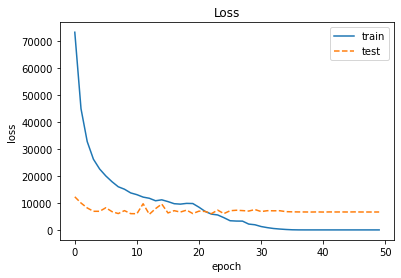

In [ ]:
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_loss_list, '-', label = "train")
plt.plot(test_loss_list, '--', label = "test")
plt.legend()
plt.savefig('loss.png', dpi=300)

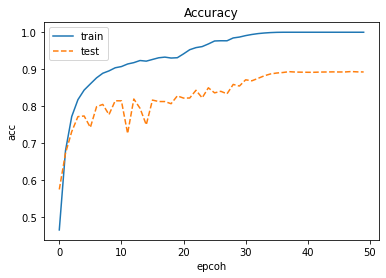

In [ ]:
plt.title("Accuracy")
plt.xlabel("epcoh")
plt.ylabel("acc")
plt.plot(train_acc_list, "-", label = "train")
plt.plot(test_acc_list, "--", label = "test")
plt.legend()
plt.savefig('accuracy.png', dpi=300)

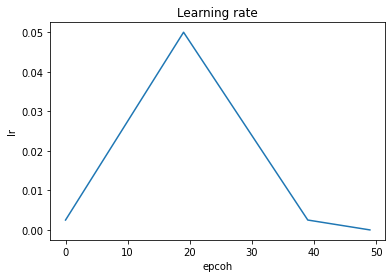

In [ ]:
plt.title("Learning rate")
plt.xlabel("epcoh")
plt.ylabel("lr")
plt.plot(lr_list)
plt.savefig('learningrate.png', dpi=300)

In [ ]:
sum(time_list) / len(time_list)

21.546712045669555

(50000, 10000)